## 讀資料

In [337]:
import pandas as pd
import numpy as np
# read train data
data=pd.read_csv("train.csv")
copy_data=data.copy()
copy_data_d=copy_data.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

features=copy_data.columns[:-1]

# read test data
test_data=pd.read_csv("X_test.csv")
test_data_d=test_data.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

# 前處理

## 前處理 1 - 刪除不採用 和 資料過少的column

In [338]:
# drop columns with too many missing values
drop_list=["D_sd1","D_sds","D_td0"]
# drop_list=[]

for col in features:
    if copy_data_d[col]["count"]<=500:
        if col not in drop_list:
            drop_list.append(col)
    if test_data_d[col]["count"]<=500:
        if col not in drop_list:
            drop_list.append(col)

copy_data=copy_data.drop(drop_list,axis=1)
test_data=test_data.drop(drop_list,axis=1)

copy_data_d=copy_data.describe(percentiles=[0.1,0.25,0.5,0.75,0.90])
test_data_d=test_data.describe(percentiles=[0.1,0.25,0.5,0.75,0.90])

## 前處理 2 - 年代處理 + outlier 處理

In [339]:
# preprocessing copy_data["D_Dbuild"]
for i in range(len(copy_data["D_Dbuild"])):
    if np.isnan(copy_data.loc[i,"D_Dbuild"]):
        continue
    if copy_data.loc[i,"D_Dbuild"]>3000 or copy_data.loc[i,"D_Dbuild"]<-3000:
        copy_data.loc[i,"D_Dbuild"]=copy_data.loc[i,"D_Dbuild"]/525960/60+1970

for col in copy_data.columns:
    for i in range(len(copy_data[col])):
        if copy_data.loc[i,col]<0:
            copy_data.loc[i,col]=0
        if copy_data.loc[i,col]>copy_data_d[col]["90%"]*10:
            copy_data.loc[i,col]=np.nan

## 前處理 3 - IterativeImputer 進行差值填補

In [340]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

imputer = IterativeImputer(estimator=BayesianRidge(max_iter=300,tol=1e-2),imputation_order='ascending',max_iter=30,random_state=42)

X=copy_data.drop(["D_isR"],axis=1)
Y=copy_data["D_isR"].to_numpy()

X_imputer=imputer.fit_transform(X)
test_data_imputer=imputer.transform(test_data)

## 前處理 4 - RobustScaler 進行正規化

In [341]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_imputer_sc=scaler.fit_transform(X_imputer)
test_data_imputer_sc=scaler.transform(test_data_imputer)

## 前處理 5 - 用 XGBoost 找 important feature

0.7819446132789462


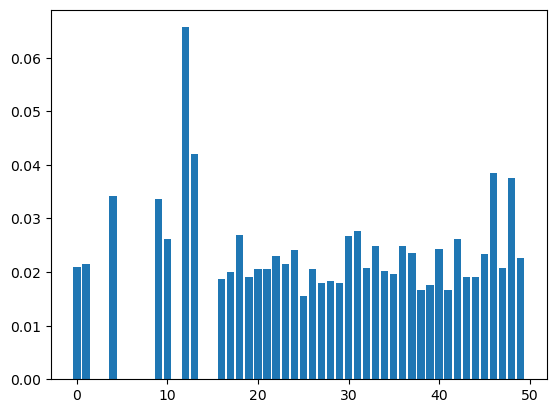

Text(0.5, 0, 'Permutation Importance')

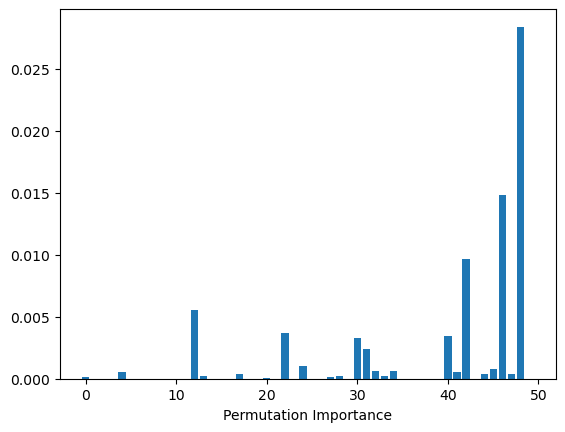

In [342]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

model=XGBClassifier(n_estimators=300, max_depth=20,learning_rate=0.1,gamma=0.2,scale_pos_weight=670/2664, random_state=42)

model.fit(X_imputer_sc, Y)

y_pred = model.predict(test_data_imputer_sc)

results = cross_val_score(model, X_imputer_sc, Y, cv=5,scoring='accuracy')
print(results.mean())

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

perm_importance_knn_sc = permutation_importance(model, X_imputer_sc, Y)
plt.bar(range(len(model.feature_importances_)), perm_importance_knn_sc.importances_mean)
plt.xlabel("Permutation Importance")

## 前處理 6 - 紀錄前8個 important features

In [343]:
importances_knn_sc=perm_importance_knn_sc.importances_mean
importances_knn_sc_frame=pd.DataFrame(importances_knn_sc)
importances_knn_sc_frame_10=importances_knn_sc_frame.nlargest(8,0)
importances_knn_sc_frame_d=importances_knn_sc_frame.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

importances_knn_sc_list=[]
for i in importances_knn_sc_frame_10[0].index:
    importances_knn_sc_list.append(copy_data.columns[i])

# for i in range(len(importances_knn_sc)):
#     if importances_knn_sc[i]>0.0000001:
#         importances_knn_sc_list.append(copy_data.columns[i])
importances_knn_sc_list

['Avg_MBfy',
 'Total_Floor',
 'D_NeutralDepth',
 'D_structure_4',
 'D_1floorClassColA',
 'D_CLsmall',
 'D_basintype',
 'D_475Acc']

## 前處理 7 - 只保留重要的 column 再做一次前處理

In [344]:
final_X=copy_data[importances_knn_sc_list]
final_test_data=test_data[importances_knn_sc_list]

imputer = IterativeImputer(estimator=BayesianRidge(max_iter=300,tol=1e-2),imputation_order='ascending',max_iter=30,random_state=42)

final_X_ip=imputer.fit_transform(final_X)
final_test_data_ip=imputer.transform(final_test_data)

scaler = RobustScaler()
final_X_ip_sc=scaler.fit_transform(final_X_ip)
final_test_data_ip_sc=scaler.transform(final_test_data_ip)

In [345]:
scaler = RobustScaler()
final_X_ip_sc=scaler.fit_transform(final_X_ip)
final_test_data_ip_sc=scaler.transform(final_test_data_ip)

## 前處理 8 - 用 SMOTE 處理不平衡資料

In [346]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
Y=copy_data["D_isR"].to_numpy()
final_X_ip_sc, Y = oversample.fit_resample(final_X_ip_sc, Y)
final_X_ip_sc.shape

(5328, 8)

# 最後預測

## 透過 confusion matrix 觀察 model 預測結果

In [347]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(final_X_ip_sc, Y, test_size=0.2, random_state=42)

model=XGBClassifier(n_estimators=400, max_depth=15,learning_rate=0.1,gamma=0.2,scale_pos_weight=1, random_state=42)

model.fit(X_train, Y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print("=======================================================")
print('Test performance')
print('------------------------')
print(classification_report(Y_test, y_test_hat))
print("=======================================================")
print('Confusion matrix')
print('------------------------')
print(confusion_matrix(Y_test, y_test_hat))
print('=======================================================')

Test performance
------------------------
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       514
           1       0.89      0.85      0.87       552

    accuracy                           0.87      1066
   macro avg       0.87      0.87      0.87      1066
weighted avg       0.87      0.87      0.87      1066

Confusion matrix
------------------------
[[456  58]
 [ 84 468]]


## 進行最後預測

In [348]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model=XGBClassifier(n_estimators=400, max_depth=17,learning_rate=0.1,gamma=0.2,scale_pos_weight=1, random_state=42)

model.fit(final_X_ip_sc, Y)

results1 = cross_val_score(model, final_X_ip_sc, Y, cv=5,scoring='accuracy')
results2 = cross_val_score(model, final_X_ip_sc, Y, cv=5,scoring='f1')

print("accuracy = ",results1.mean())
print("f1 = ",results2.mean())

y_pred = model.predict(final_test_data_ip_sc)


accuracy =  0.8549420852821745
f1 =  0.8658025713584319


## 儲存預測結果

In [349]:
id=np.linspace(1, len(y_pred),len(y_pred))
pred=pd.DataFrame({'id':id,'label':y_pred})
pred.to_csv('pred.csv',index=False)